<h1>Predicting Customer Churn<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>


**Loading Packages**

In [92]:
import numpy as np
import pandas as pd
import os
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt 

from sklearn import metrics
import matplotlib.pyplot as plt 
os.chdir(r'C:\Users\ricci\Desktop\Coding & Techniques\GitHub\Predicting Customer Churn')
churn = pd.read_csv('Churn2.csv')

**Data Preparation**

In [9]:
#detect missing values
churn.isnull().sum()

Account Length    0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn             0
dtype: int64

In [55]:
#create dummy variables for categorical variables
intplan = pd.get_dummies(churn['Int\'l Plan'])
intplan.columns=['intplan_no','intplan_yes']
vmail = pd.get_dummies(churn['VMail Plan'])
vmail.columns=['vmail_no','vmail_yes']

churn_dummy = pd.concat([churn,intplan,vmail],axis=1)
churn_dummy = churn_dummy.drop(columns=["Int\'l Plan","VMail Plan"])

In [13]:
#create training and testing data sets for data sets containing dummy variables
training_set, test_set = train_test_split(churn_dummy,test_size=0.3,random_state=0)

X_train = training_set.drop(['Churn'],axis=1)
Y_train = training_set.iloc[:,-5]
X_test = test_set.drop(['Churn'],axis=1)
Y_test = test_set.iloc[:,-5]

**Logistic Regression**

In [61]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

print(sm.Logit(Y_train,X_train).fit().summary2())

Optimization terminated successfully.
         Current function value: 0.327443
         Iterations 8
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     0.219     
Dependent Variable:      Churn                AIC:                  1563.8480 
Date:                    2020-06-04 13:54     BIC:                  1667.4364 
No. Observations:        2333                 Log-Likelihood:       -763.92   
Df Model:                17                   LL-Null:              -977.55   
Df Residuals:            2315                 LLR p-value:          3.6555e-80
Converged:               1.0000               Scale:                1.0000    
No. Iterations:          8.0000                                               
------------------------------------------------------------------------------
                Coef.     Std.Err.      z    P>|z|      [0.025       0.975]   
-------------------------------------------------------------

C:\Users\ricci\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [65]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'
      .format(logreg.score(X_test, Y_test)))
logreg_mrate = 1-metrics.accuracy_score(y_pred, Y_test)
logreg_mrate
from sklearn.metrics import confusion_matrix
logregconfusion_matrix = confusion_matrix(Y_test, y_pred)
print(logregconfusion_matrix)

Accuracy of logistic regression classifier on test set: 0.86
[[843  19]
 [124  14]]


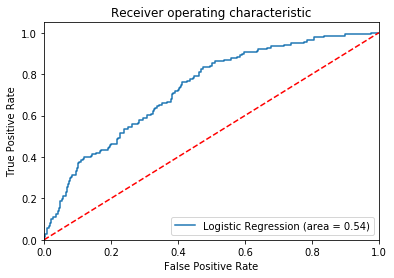

In [15]:
#plot ROC curve
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

**Random Forest**

In [17]:
# tune parameter
# n_estimators and max_features； Iterate and pick the best result
max_features = list(range(4,16))
n_estimators = [40,60,80,100,120]

rf_result=pd.DataFrame(columns=['Number of Variables', 'Number of Trees','Mis_Rate'])
for n_estimator in n_estimators:
    for max_feature in max_features:
        rf = RandomForestClassifier(n_estimators=n_estimator,max_features=max_feature, random_state=1)
        rf.fit(X_train, Y_train)
        rf_predict = rf.predict(X_test)
        rf_mrate = 1-metrics.accuracy_score(rf_predict, Y_test)
        rf_result=rf_result.append({'Number of Variables':max_feature,'Number of Trees':n_estimator,'Mis_Rate':rf_mrate},ignore_index=True)

rf_result

,Number of Variables,Number of Trees,Mis_Rate
0,4.0,40.0,0.042
1,5.0,40.0,0.041
2,6.0,40.0,0.046
3,7.0,40.0,0.044
4,8.0,40.0,0.047
5,9.0,40.0,0.046
6,10.0,40.0,0.047
7,11.0,40.0,0.049
8,12.0,40.0,0.049
9,13.0,40.0,0.047


In [66]:
rf_min=rf_result[rf_result['Mis_Rate']==min(rf_result.iloc[:,-1])]

rf = RandomForestClassifier(n_estimators=80,max_features=5, random_state=1)
rf.fit(X_train, Y_train)
rf_predict = rf.predict(X_test)
rf_train = rf.predict(X_train)
rf_mrate = 1-metrics.accuracy_score(rf_predict, Y_test)
print('\nNumber of Trees: 80','\nNumber of Variables: 5','\nMisclassification Rate: %s'%rf_min.iloc[0,-1])


Number of Trees: 80 
Number of Variables: 5 
Misclassification Rate: 0.040000000000000036


In [19]:
from sklearn.metrics import confusion_matrix
rfconfusion_matrix = confusion_matrix(Y_test, rf_predict)
print(rfconfusion_matrix)

[[851  11]
 [ 29 109]]


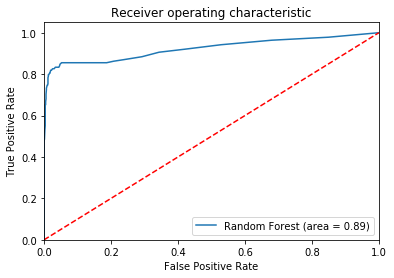

In [20]:
#ROC Curve
rf_roc_auc = roc_auc_score(Y_test, rf_predict)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(Y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('rf_ROC')
plt.show()

**Visualization RF Model**

In [116]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
from io import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [117]:
# Extract single tree
estimator = rf.estimators_[79]
estimator

DecisionTreeClassifier(max_features=5, random_state=532704722)

In [118]:
dot_data = StringIO()
feature_cols=X_train.columns
export_graphviz(estimator, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

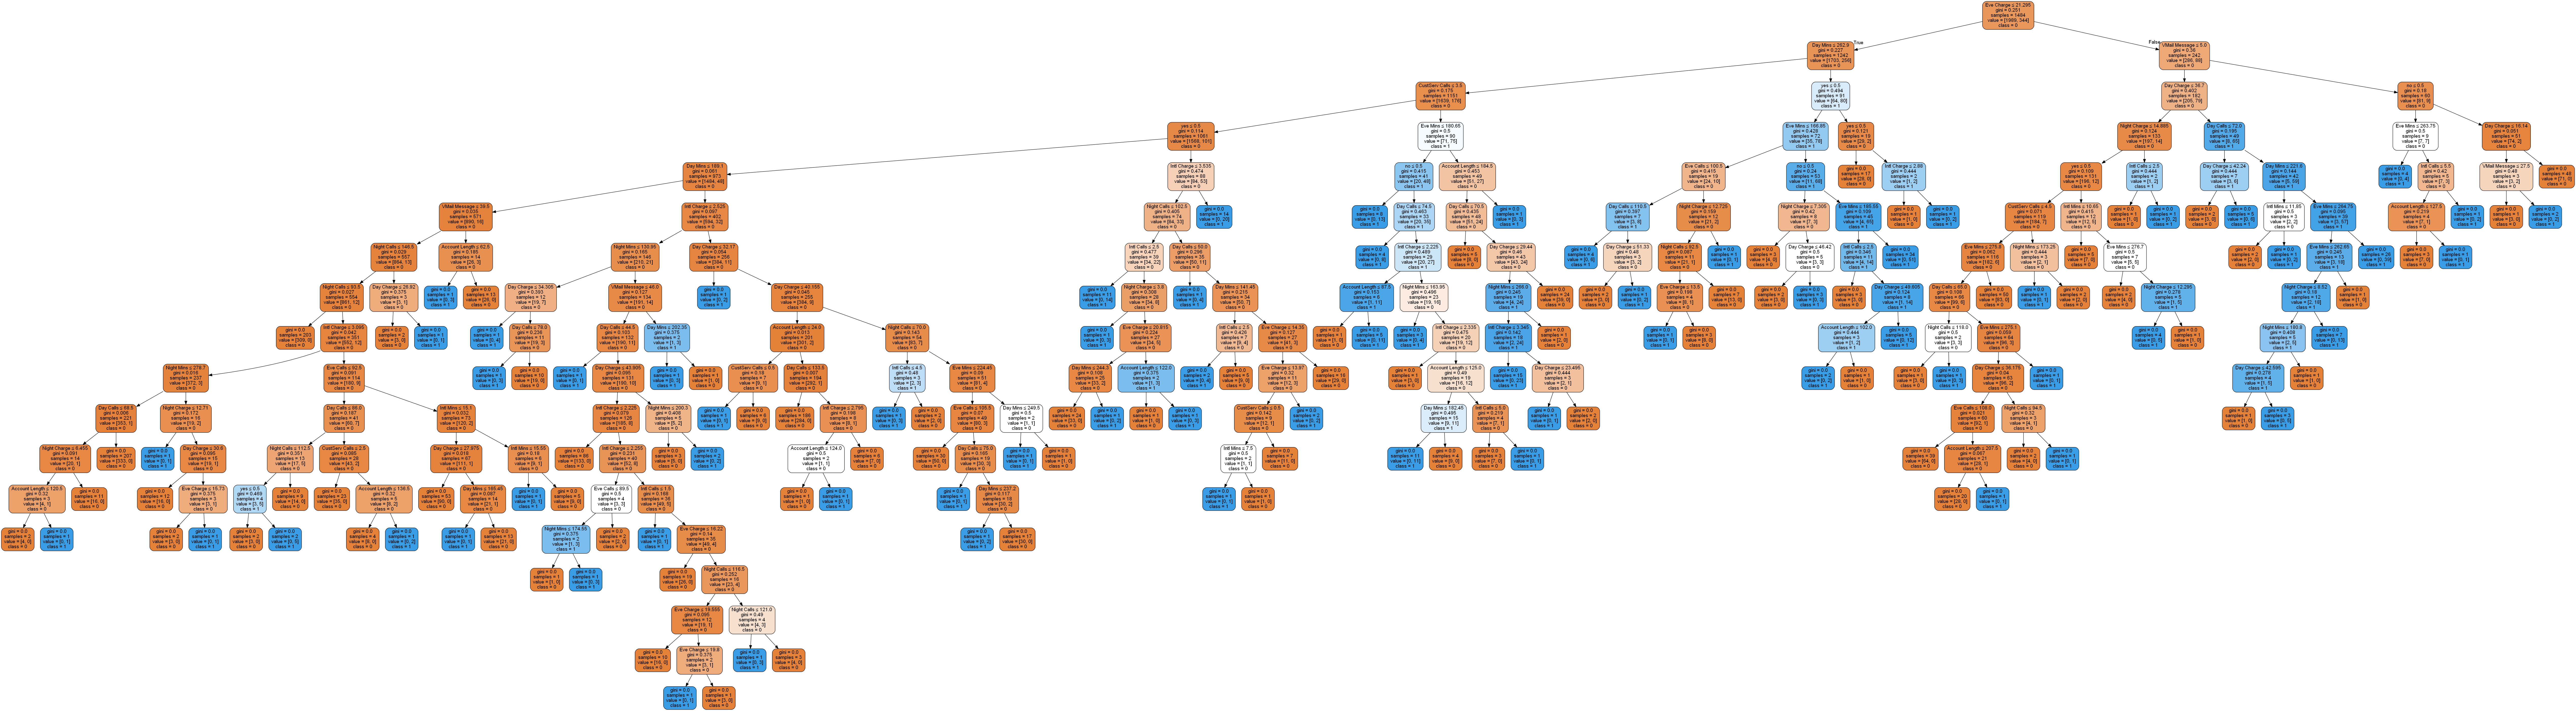

In [119]:
graph.write_png('RF_churn.png')
Image(graph.create_png())

**Gradient Boosting**

In [26]:
n_estimators = [40,60,80,100,120]
max_features = list(range(4,16))
learning_rates = [0.1,0.05,0.01]

gbdt_result=pd.DataFrame(columns=['Learning Rate', 'Number of Variables', 'Number of Trees','Mis_Rate'])
for rate in learning_rates:
    for max_feature in max_features:
        for n_estimator in n_estimators:
            gbdt = GradientBoostingClassifier(learning_rate=rate, n_estimators=n_estimator, max_features=max_feature, random_state=2)
            gbdt.fit(X_train, Y_train)
            gbdt_predict = gbdt.predict(X_test)
            gbdt_mrate = 1-metrics.accuracy_score(gbdt_predict, Y_test)
            gbdt_result=gbdt_result.append({'Learning Rate':rate,'Number of Variables':max_feature,'Number of Trees':n_estimator,'Mis_Rate':gbdt_mrate},ignore_index=True)

print(gbdt_result)

     Learning Rate  Number of Variables  Number of Trees  Mis_Rate
0             0.10                  4.0             40.0     0.060
1             0.10                  4.0             60.0     0.054
2             0.10                  4.0             80.0     0.048
3             0.10                  4.0            100.0     0.049
4             0.10                  4.0            120.0     0.048
..             ...                  ...              ...       ...
175           0.01                 15.0             40.0     0.138
176           0.01                 15.0             60.0     0.129
177           0.01                 15.0             80.0     0.098
178           0.01                 15.0            100.0     0.091
179           0.01                 15.0            120.0     0.090

[180 rows x 4 columns]


In [38]:
gbdt_min=gbdt_result[gbdt_result['Mis_Rate']==min(gbdt_result.iloc[:,-1])]
gbdt_min

,Learning Rate,Number of Variables,Number of Trees,Mis_Rate
116,0.05,15.0,60.0,0.046


In [46]:
gbdt = GradientBoostingClassifier(learning_rate=0.05, n_estimators=60, max_features=15, random_state=2)
gbdt.fit(X_train, Y_train)
gbdt_predict = gbdt.predict(X_test)
gbdt_mrate = 1-metrics.accuracy_score(gbdt_predict, Y_test)
print('Accuracy of Gradient Boosting on test set: {:.4f}'
      .format(gbdt_mrate),'\nAUC: {:.4f}'
      .format(roc_auc_score(Y_test, gbdt_predict)))

Accuracy of Gradient Boosting on test set: 0.0460 
AUC: 0.8638


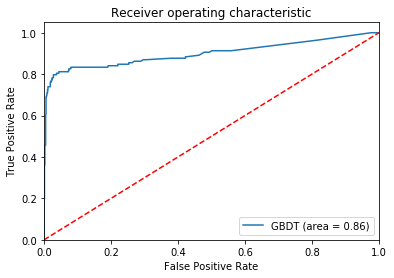

In [48]:
#ROC Curve
gbdt_roc_auc = roc_auc_score(Y_test, gbdt_predict)
gbdt_fpr, gbdt_tpr, gbdt_thresholds = roc_curve(Y_test, gbdt.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(gbdt_fpr, gbdt_tpr, label='GBDT (area = %0.2f)' % gbdt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('gbdt_ROC')
plt.show()